In [1]:
!pip install opendatasets -q

# Import Libraries

In [4]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

<ipython-input-4-4d64df52c937>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Data Loading

In [5]:
od.download("https://www.kaggle.com/datasets/ryanholbrook/dl-course-data")

Dataset URL: https://www.kaggle.com/datasets/ryanholbrook/dl-course-data


100%|██████████| 231M/231M [00:12<00:00, 19.1MB/s]


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1984


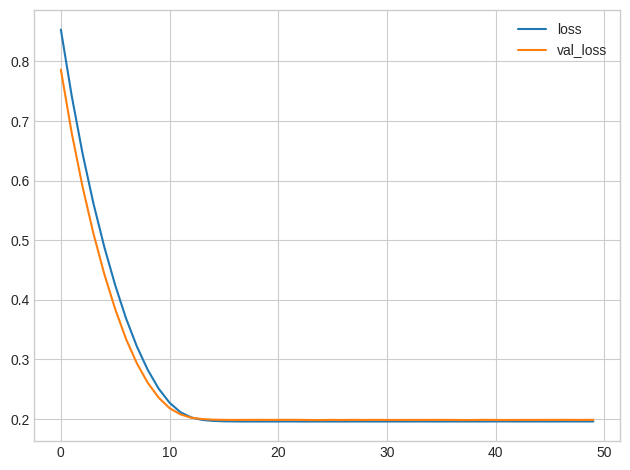

In [8]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1984


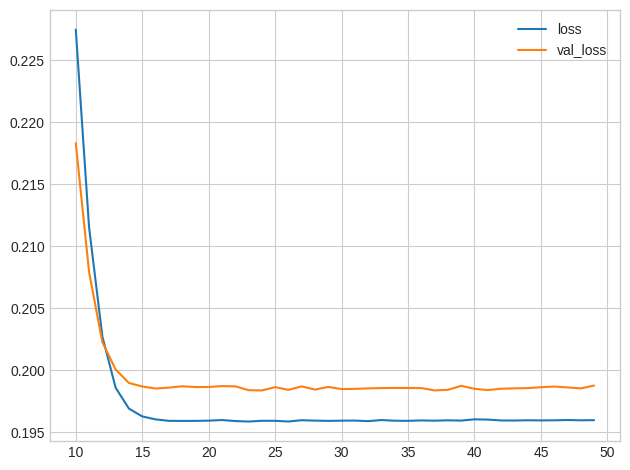

In [9]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate baseline

the model is underfitting

Epoch 1/50
49/49 [==============================] - 2s 17ms/step - loss: 0.2200 - val_loss: 0.2069
Epoch 2/50
49/49 [==============================] - 0s 9ms/step - loss: 0.1979 - val_loss: 0.2041
Epoch 3/50
49/49 [==============================] - 1s 12ms/step - loss: 0.1940 - val_loss: 0.2014
Epoch 4/50
49/49 [==============================] - 1s 10ms/step - loss: 0.1911 - val_loss: 0.2000
Epoch 5/50
49/49 [==============================] - 1s 13ms/step - loss: 0.1900 - val_loss: 0.2006
Epoch 6/50
49/49 [==============================] - 0s 10ms/step - loss: 0.1885 - val_loss: 0.1983
Epoch 7/50
49/49 [==============================] - 1s 10ms/step - loss: 0.1872 - val_loss: 0.2001
Epoch 8/50
49/49 [==============================] - 1s 15ms/step - loss: 0.1862 - val_loss: 0.1986
Epoch 9/50
49/49 [==============================] - 1s 15ms/step - loss: 0.1852 - val_loss: 0.1987
Epoch 10/50
49/49 [==============================] - 1s 14ms/step - loss: 0.1845 - val_loss: 0.1987
Epoch 11/5

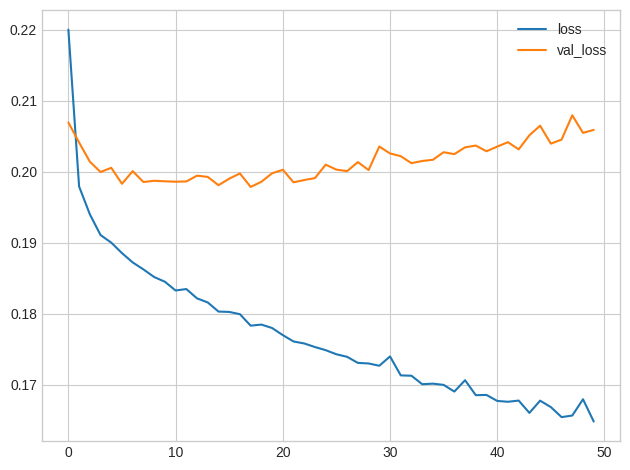

In [10]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add capacity

the model is overfitting

# 3) Define earlystopping callback

In [11]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

Epoch 1/50
49/49 [==============================] - 2s 12ms/step - loss: 0.2380 - val_loss: 0.2110
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.2028 - val_loss: 0.2066
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1973 - val_loss: 0.2024
Epoch 4/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1940 - val_loss: 0.2012
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1917 - val_loss: 0.2023
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1903 - val_loss: 0.2011
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1885 - val_loss: 0.1982
Epoch 8/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1872 - val_loss: 0.1987
Epoch 9/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1863 - val_loss: 0.1980
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1853 - val_loss: 0.1977
Epoch 11/50
49/49 

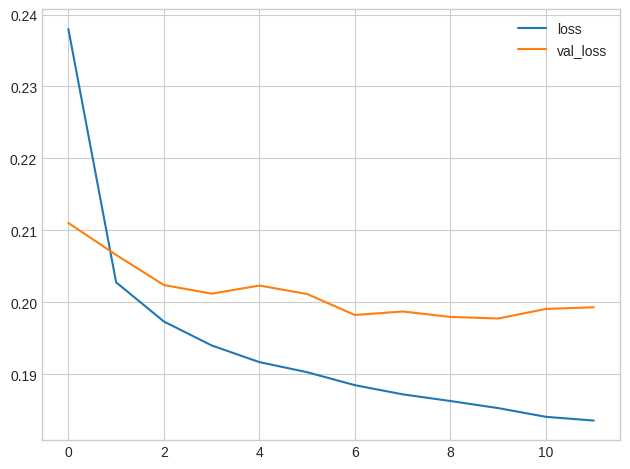

In [12]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and interpret

The model is no longer overfitting, early stopping is helping the model